# Investigate possible effect(s) of suppressed growth on early halo mass function and JWST high-redshift massive galaxies

## Literature background

### JWST massive galaxy and possible tension with $\Lambda$CDM halo & stellar mass function
- Boylan-Kolchin (2023): https://www.nature.com/articles/s41550-023-01937-7
- Lovell et al. (2023): https://academic.oup.com/mnras/article/518/2/2511/6823705 [EVS paper]
- Sabti, Munõz, Kamionkowski (2023): https://arxiv.org/abs/2305.07049

### Earlier hints for a possible tension
- Steinhardt et al. (2016): https://iopscience.iop.org/article/10.3847/0004-637X/824/1/21 (some hint)
- Behroozi, Silk (2016): https://academic.oup.com/mnras/article/477/4/5382/4975781?login=false (no hint)

### Some notes about the universality of the halo mass function and possible issues with calibration at high redshift and high-mass end
- Asgari, Mead, Heymans (2023): https://arxiv.org/abs/2303.08752 (See their Table 1 for a quick summary)
- Lukić et al. (2007): https://iopscience.iop.org/article/10.1086/523083/
- Ondaro-Mallea et al. (2021): https://arxiv.org/abs/2102.08958 (Extra $f$-dependence of the halo multiplicity function)

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('Minh_paper_style') # comment this line and specify your style instead

# https://github.com/astropy/astropy - https://arxiv.org/abs/2206.14220
import astropy
import astropy.units as au

# https://github.com/alexander-mead/pyhalomodel - https://arxiv.org/abs/2303.08752
import pyhalomodel as hm
# import pyhalomodel.camb_stuff as camb_stuff # we want our modified camb so skipping this

# https://github.com/LSSTDESC/CCL - https://arxiv.org/abs/1812.05995
import pyccl as ccl

# https://github.com/MinhMPA/CAMB_GammaPrime_Growth - https://arxiv.org/abs/2302.01331
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /Users/nguyenmn/CAMB_GammaPrime_Growth/camb


## $\Lambda$CDM cosmological parameters and halo mass range

In [120]:
# Cosmology in Planck 2018 paper - Plik best fit in Table 1
PL18_h=0.6732
PL18_omch2=0.12011
PL18_ombh2=0.022383
PL18_omh2=0.14314
PL18_nuh2=PL18_omh2-PL18_omch2-PL18_ombh2
PL18_mnu=0.06
PL18_Omegak=0.0
PL18_As=np.exp(3.0448)/1E10
PL18_ns=0.96605
PL18_tau=0.0543
PL18_w0=-1.0
PL18_wa=0.0
## Growh-index gamma(z) parameters
GR_gamma0=0.55
GR_gamma1=0.

# Cosmology in EVS paper
EVS_h=0.678
EVS_Omegam=0.309
EVS_Omegab=0.0486
EVS_ombh2=EVS_Omegab*(EVS_h**2)
EVS_Omegac=EVS_Omegam-EVS_Omegab # EVS paper did not specify whether they include/exclude Omeganu in Omegam
EVS_omch2=EVS_Omegac*(EVS_h**2)
EVS_Omegak=0.
EVS_sigma8=0.816

# Redshifts
z = 0.
## CAMB reorders input redshifts high-z -> low-z, let us define it like this from the start to avoid confusion
zs = np.array([16.,12.,8.,4.,2.,0.])

## Compute linear matter power spectrum and other quantities using CAMB

### Universal CAMB parameters

In [121]:
CAMB_ellmax=2500
CAMB_lens_potential_accuracy=1 # 0 - linear, >=1 - nonlinear
CAMB_kmax=20.

### $\Lambda$CDM - PL18

In [122]:
LCDM_pars = camb.CAMBparams();
#PL18 baseline assumes one massive neutrino whereas helium is set using BBN consistency
LCDM_pars.WantTransfer = True;
LCDM_pars.NonLinear = model.NonLinear_both
LCDM_pars.set_matter_power(redshifts=zs, kmax=CAMB_kmax)
LCDM_pars.set_cosmology(H0=PL18_h*100., ombh2=PL18_ombh2, omch2=PL18_omch2, mnu=PL18_mnu, omk=PL18_Omegak, tau=PL18_tau, gamma0=0.55,gamma1=0.0);
LCDM_pars.InitPower.set_params(As=PL18_As, ns=PL18_ns, r=0) # no running of spectral index
LCDM_pars.set_for_lmax(CAMB_ellmax, lens_potential_accuracy=CAMB_lens_potential_accuracy);
LCDM_results = camb.get_results(LCDM_pars);

### $\gamma$CDM - NHW23

In [123]:
# NHW23 gamma index
NHW_gamma0=0.633
NHW_gamma1=0.0

# WNH23 gamma indices
WNH23_gamma0=0.621
WNH23_gamma1=0.149

gCDM_pars = camb.CAMBparams();
gCDM_pars.WantTransfer = True;
gCDM_pars.NonLinear = model.NonLinear_both
gCDM_pars.set_matter_power(redshifts=zs, kmax=CAMB_kmax)
# For now, assuming PL18 for LCDM parameters, which is not correct. Must update with best-fit values from NHW23 chains
gCDM_pars.set_cosmology(H0=PL18_h*100., ombh2=PL18_ombh2, omch2=PL18_omch2, mnu=PL18_mnu, omk=PL18_Omegak, tau=PL18_tau, gamma0=NHW_gamma0,gamma1=NHW_gamma1);
gCDM_pars.InitPower.set_params(As=PL18_As, ns=PL18_ns, r=0) # no running of spectral index
gCDM_pars.set_for_lmax(CAMB_ellmax, lens_potential_accuracy=CAMB_lens_potential_accuracy);
gCDM_results = camb.get_results(gCDM_pars);

## Compute halo mass function $\frac{dn(z)}{d\log_{10}M_h}$

### Halo mass range for testing `pyhalomodel` and `pyccl`

In [124]:
# Halo mass range [Msun/h]
## Min - Max
Mmin = 1e6; Mmax = 6e16 # maxium range wherein pyccl hmf module still works
## Number of points to sample within Mmin - Mmax
nM = 1024 # any nM>=128 works fine
## Halo mass range - equally spaced in log10
Ms = np.geomspace(Mmin, Mmax, nM)

### Using pyhalomodel

Below,

`Dv` is the halo overdensity definition --> Match it with `MassDef` in `ccl.halos.massdef` below during cross-checking;

`dc` is the linear collapse threshold.

`pyhalomodel` adopts units *with* `h`. It outputs $\frac{dn(z)}{dM_h}\,[hM_\odot^{-1}h^3\mathrm{Mpc}^{-3}]$.

In [125]:
# First-order thing to do is implement Reed et al. (2007) or Watson et al. (2013) halo mass functions, or anything from
# Table 1 of arXiv:2303.08752 that was fitted/calibrated at z>=10
## Second-order thing to do is to implement Ondaro-Mallea et al. (2021) halo mass function,
## which includes extra sensitivity to growth rate in the halo multiplicity function

# But let us assume Tinker et al. (2010) for now...
hm_mass_functions = [
    'Tinker et al. (2010)'
]

hm_hmfs = np.full([zs.shape[0],Ms.shape[0]],np.nan) # filled with NaNs to make debugging easy
for iz, z in enumerate(zs):
    for mass_function in hm_mass_functions:
        #print(mass_function, 'z = %1.1f'%(z)) # check mass function, redshift
        hmod = hm.model(z, Om_m=PL18_omh2/(PL18_h**2), name=mass_function, Dv=200.,dc=1.686)
        Rs = hmod.Lagrangian_radius(Ms) # halo Lagrangian radius R_L(M_h)
        sigmaRs = LCDM_results.get_sigmaR(Rs, z_indices=iz, hubble_units=True, return_R_z=False)
        hmf = hmod.mass_function(Ms, sigmaRs)
        #hmf = hmod.multiplicity_function(Ms, sigmaRs) # "universal" halo multiplicity function
        hm_hmfs[iz,:] = hmf

### Using pyccl as a cross-check

`pyccl` adopts units without $h$. It outputs $\frac{dn(z)}{d\log_{10}M_h}\,[\mathrm{Mpc}^{-3}]$.

In [126]:
# Cosmology
ccl_LCDM_cosmo = ccl.Cosmology(Omega_c=PL18_omch2/(PL18_h**2), Omega_b=PL18_ombh2/(PL18_h**2),
                      h=PL18_h, A_s=PL18_As, n_s=PL18_ns)
# Mass definition
ccl_massdef_200m = ccl.halos.MassDef200m #can also do this directly
#ccl_massdef_200m = ccl.halos.MassDef(200, 'matter')

ccl_hmfs=[]
ccl_tinker_hmf_200m=ccl.halos.MassFuncTinker10(mass_def=ccl_massdef_200m,\
                                               norm_all_z=True)
# Mass function - Tinker et al. (2010)
ccl_hmfs = np.full_like(hm_hmfs,np.nan)
for iz,z in enumerate(zs):
    ccl_hmfs[iz,:]=ccl_tinker_hmf_200m(ccl_LCDM_cosmo,Ms/(PL18_h),1./(1.+z))

### Compare halo mass function outputs by `pyhalomodel` and `pyccl`

Tinker et al. (2010) mass function

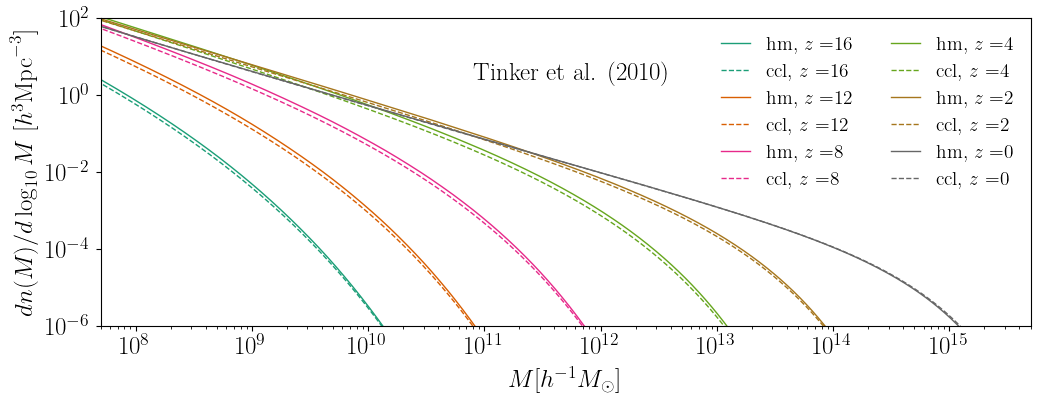

In [129]:
fig,ax=plt.subplots(figsize=(12, 4), dpi=100)
Mmin_plot, Mmax_plot = 5e7, 5e15

color = iter(cm.Dark2(np.linspace(0, 1, len(zs))))
for iz, z in enumerate(zs):
    #ax.semilogx(Ms, fs[i],c='k', ls='--',label=r'Tinker, $z=1.$')
    #ax.semilogx(Ms, fs[i+n],c='k', ls='-',label=r'Tinker, $z=0.$')
    c=next(color)
    ax.loglog(Ms, (Ms*np.log(10.))*hm_hmfs[iz,:],c=c, ls='-',label=r'hm, $z=$%.f'%z)
    ax.loglog(Ms, ccl_hmfs[iz,:]/(PL18_h**3),c=c, ls='--',label=r'ccl, $z=$%.f'%z)
ax.set_ylim(1e-6,1e2)
ax.set_ylabel(r'$dn(M)/d\log_{10}M$ [$h^3\mathrm{Mpc}^{-3}$]')
#plt.ylim(0.,0.06)
#plt.ylabel(r'$M^2 n(M)/\bar\rho$') #if plotting hmod.multiplicity_function
ax.set_xlabel(r'$M[h^{-1}M_\odot]$')
ax.set_xlim((Mmin_plot, Mmax_plot))
ax.text(0.4,0.8,'Tinker et al. (2010)',transform=ax.transAxes)
plt.legend(fontsize=14,ncols=2,loc='upper right',handlelength=1.5)

### Halo mass range for main computations

Now that we're confident that `pyhalomodel` works as intended, we re-define halo mass range for the main computations that follow.

In [86]:
Mmin = 1e5; Mmax = 1e18 # extended range, still supported by pyhalomodel
nM = 2048
Ms = np.geomspace(Mmin, Mmax, nM)

### Halo mass function for main computations

In [87]:
hm_mass_functions = 'Tinker et al. (2010)'

hm_hmfs = np.full([zs.shape[0],Ms.shape[0]],np.nan) # filled with NaNs to make debugging easy
for iz, z in enumerate(zs):
    #print(mass_function, 'z = %1.1f'%(z)) # check mass function, redshift
    hmod = hm.model(z, Om_m=PL18_omh2/(PL18_h**2), name=mass_function, Dv=200.,dc=1.686)
    Rs = hmod.Lagrangian_radius(Ms) # halo Lagrangian radius R_L(M_h)
    sigmaRs = LCDM_results.get_sigmaR(Rs, z_indices=iz, hubble_units=True, return_R_z=False)
    hmf = hmod.mass_function(Ms, sigmaRs)
    #hmf = hmod.multiplicity_function(Ms, sigmaRs) # "universal" halo multiplicity function
    hm_hmfs[iz,:] = hmf

## Compute $F(m;z)$

$F(m;z)$ is the cumulative distribution of halo mass $M_h\leq m$ at redshift $z$, as described in Eq(6) of [arXiv:2208.10479](https://arxiv.org/abs/2208.10479).
Assuming Tinker et al. (2010) mass function.
Basically, we insert the halo mass function $\frac{dn}{dM}$ output by `pyhalomodel` into $\frac{dn}{dM}$ in the paper.

In [88]:
from scipy.integrate import cumtrapz

Fs=np.full(hm_hmfs.shape,np.nan)
for iz in range(len(zs)):
        Fs[iz,:]=cumtrapz(hm_hmfs[iz,:],x=Ms,initial=0.)
ntot=Fs[:,-1]
Fs=Fs/ntot[:,np.newaxis]
print(r'Norm factor ntot='+str(ntot))

Norm factor ntot=[ 5619.81156925 12338.61766089 18717.80418395 18407.45255286
 14676.68966838  9171.62852725]


## Visualize $F(m;z)$

$F(m;z)$ should sharply rise to unity at any given $z$, *sharper* for *higher* $z$.

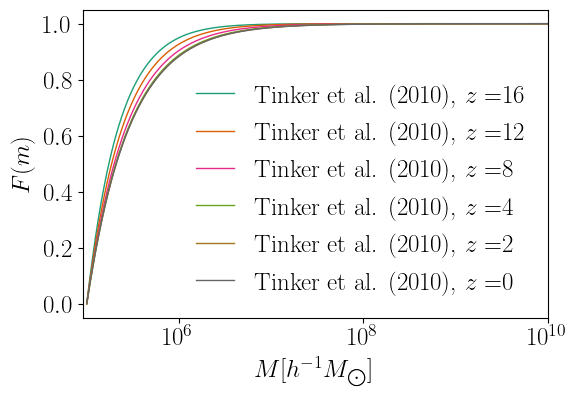

In [89]:
fig,ax=plt.subplots(figsize=(6, 4), dpi=100)
Mmin_plot, Mmax_plot = 9e4, 1e10

color = iter(cm.Dark2(np.linspace(0, 1, len(zs))))
for iz, z in enumerate(zs):
    c=next(color)
    plt.semilogx(Ms, Fs[iz,:],c=c, ls='-',label=r'Tinker et al. (2010), $z=$%.f'%z)
#plt.ylim(1e-20,1e4)
ax.set_ylabel(r'$F(m)$')
ax.set_xlabel(r'$M[h^{-1}M_{\bigodot}]$')
ax.set_xlim((Mmin_plot, Mmax_plot))
plt.legend(handlelength=1.5)

## Compute the exact EVS $\Phi(M_{\mathrm{max}}=m;z)$

Try to reproduce Fig. 1 of [arXiv:2208.10479](https://arxiv.org/abs/2208.10479).
Assuming the same volume $V=100^3\,[\mathrm{Mpc}^3]$.
Assuming Tinker et al. (2010) mass function, instead of Behroozi et al. (2013) (as in that paper, but not too important).

Our `Phi` is given by Eq(4) of [arXiv:2208.10479](https://arxiv.org/abs/2208.10479).

In [117]:
V=((100.*PL18_h)**3)
N=ntot*V
#N=(1E3)*(ntot/ntot) # Uncomment this and change the pre-factor to see the effect of varying N on Phi
print(N)
Phi=N[:,np.newaxis]*(hm_hmfs/ntot[:,np.newaxis])*Fs**(N[:,np.newaxis]-1)
#Phi=Phi/np.trapz(Phi,x=Ms)[:,np.newaxis] # normalize Phi so that it integrates to 1, regardless of N
Phi=Phi/Phi.max(axis=1)[:,np.newaxis] # normalize Phi by the peak so that the maximum is always 1

[1.71456548e+09 3.76442656e+09 5.71067206e+09 5.61598594e+09
 4.47775609e+09 2.79820017e+09]


Text(0, 0.5, '$\\Phi(M^{\\mathrm{max}}_{200}|z,V)$')

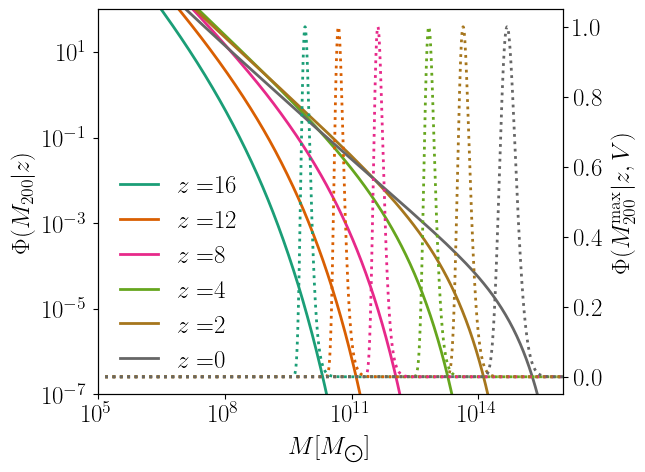

In [118]:
fig,ax1=plt.subplots(figsize=(6, 5), dpi=100)
Mmin_plot, Mmax_plot = 1e5, 1e16

color = iter(cm.Dark2(np.linspace(0, 1, len(zs))))
for iz, z in enumerate(zs):
    c = next(color)
    ax1.loglog(Ms/PL18_h, (Ms*np.log(10.))*hm_hmfs[iz,:]*(PL18_h**3),c=c,ls='-',lw=2.,label=r'$z=$%.f'%z)
ax1.set_ylabel(r'$\Phi(M_{200}|z)$')
ax1.set_xlabel(r'$M[M_{\bigodot}]$')
ax1.set_ylim(1e-7,1e2)
ax1.set_xlim((Mmin_plot, Mmax_plot))
plt.legend(handlelength=1.5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = iter(cm.Dark2(np.linspace(0, 1, len(zs))))
for iz, z in enumerate(zs):
    c = next(color)
    ax2.semilogx(Ms/PL18_h, Phi[iz,:], c=c,ls=':',lw=2.)
#ax2.set_ylim(0,Phi[-1,:].max()) # uncomment this to zoom in on the y-axis
ax2.set_ylabel(r'$\Phi(M^{\mathrm{max}}_{200}|z,V)$')